In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import math
from sklearn.model_selection import train_test_split
from geopy.geocoders import Nominatim

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import geoplot

import matplotlib.pyplot as plt

/tmp/ipykernel_642200/1463191839.py:10: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


# Importación del CSV

In [2]:
datapath = 'data'
df = pd.read_csv(os.path.join(datapath, 'uber_fares.csv'))
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5
...,...,...,...,...,...,...,...
199994,3.0,2012-10-28 10:49:00 UTC,-73.987042,40.739367,-73.986525,40.740297,1
199995,7.5,2014-03-14 01:09:00 UTC,-73.984722,40.736837,-74.006672,40.739620,1
199996,30.9,2009-06-29 00:42:00 UTC,-73.986017,40.756487,-73.858957,40.692588,2
199997,14.5,2015-05-20 14:56:25 UTC,-73.997124,40.725452,-73.983215,40.695415,1


In [3]:
#df.dtypes

# Preprocesamiento de los datos

In [4]:
# Sustituimos las fechas por timestamps
# df['pickup_timestamp'] = df['pickup_datetime'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC').timestamp())
df['pickup_timestamp'] = df['pickup_datetime'].apply(lambda x: pd.Timestamp(x))
df['pickup_monthday'] = df['pickup_timestamp'].apply(lambda x: x.day)
df['pickup_weekday'] = df['pickup_timestamp'].apply(lambda x: x.weekday)
df.drop('pickup_datetime', axis=1, inplace=True)
df.drop('pickup_timestamp', axis=1, inplace=True)

### Cálculo de la distancia mediante el semiverseno
El semiverseno se utiliza para calcular la distancia en la superfície de una esfera dadas las coordenadas de los puntos en la misma.

Fórmula del semiverseno utilizada: 

$$ semiversin\left({d\over R}\right) = semiversin(φ_1 - φ_2) + cos(φ_1) cos(φ_2) semiversin(\small \Delta λ) $$

Donde:
* $d$ es la distancia entre dos los dos puntos
* $R$ es el radio de la esfera
* $φ_1$ es la latitud del punto 1
* $φ_2$ es la latitud del punto 2
* $\small \Delta λ$ es la la diferencia de longitudes de los puntos

In [5]:
# Función que calcula la distancia en la tierra entre dos pares de coordenadas usando el semiverseno, devuelve la distancia en metros
def coordsToDistance(long1: float, lat1: float, long2: float, lat2: float):
    # Radio de la tierra aprox
    R = 6367000
    # Grados a radianes
    degToRad = math.pi / 180

    distLong = (long2 - long1) * degToRad
    distLat = (lat1 - lat2) * degToRad
    
    a = (math.sin(distLat / 2) ** 2) + (math.cos(lat1 * degToRad) * math.cos(lat2 * degToRad) * (math.sin(distLong / 2) ** 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c
    return d


In [6]:
# Reemplazamos las columnas de las coordenaas con la distancia
coords:np.ndarray = df[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']].to_numpy()
distances = np.apply_along_axis(lambda x: coordsToDistance(x[0], x[1], x[2], x[3]), 1, coords)
df.insert(2, 'distance_run', pd.Series(distances))
# df = df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1 )
df.head()



,fare_amount,pickup_longitude,distance_run,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_monthday,pickup_weekday
0,7.5,-73.999817,1682.265887,40.738354,-73.999512,40.723217,1,7,3
1,7.7,-73.994355,2456.046898,40.728225,-73.994710,40.750325,1,17,4
2,12.9,-74.005043,5033.215126,40.740770,-73.962565,40.772647,1,24,0
3,5.3,-73.976124,1660.640179,40.790844,-73.965316,40.803349,3,26,4
4,16.0,-73.925023,4472.640074,40.744085,-73.973082,40.761247,5,28,3


### Limpieza de datos
Datos a eliminar:
* Viajes con mas de 6 pasajeros
* Viajes muy cortos o muy largos
* Viajes precios desorbitados
* etc...

In [7]:
df.drop(df[df['distance_run'] > 60000].index, inplace=True)
df.drop(df[df['distance_run'] < 10].index, inplace=True)
df.drop(df[df['fare_amount'] > 100].index, inplace=True)
df.drop(df[df['fare_amount'] < 1].index, inplace=True)
df.drop(df[df['pickup_latitude'] > 50].index, inplace=True)
df.drop(df[df['pickup_latitude'] < 10].index, inplace=True)

In [8]:
df

,fare_amount,pickup_longitude,distance_run,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_monthday,pickup_weekday
0,7.5,-73.999817,1682.265887,40.738354,-73.999512,40.723217,1,7,3
1,7.7,-73.994355,2456.046898,40.728225,-73.994710,40.750325,1,17,4
2,12.9,-74.005043,5033.215126,40.740770,-73.962565,40.772647,1,24,0
3,5.3,-73.976124,1660.640179,40.790844,-73.965316,40.803349,3,26,4
4,16.0,-73.925023,4472.640074,40.744085,-73.973082,40.761247,5,28,3
...,...,...,...,...,...,...,...,...,...
199994,3.0,-73.987042,112.139794,40.739367,-73.986525,40.740297,1,28,6
199995,7.5,-73.984722,1873.872926,40.736837,-74.006672,40.739620,1,14,4
199996,30.9,-73.986017,12842.251110,40.756487,-73.858957,40.692588,2,29,0
199997,14.5,-73.997124,3537.493059,40.725452,-73.983215,40.695415,1,20,2


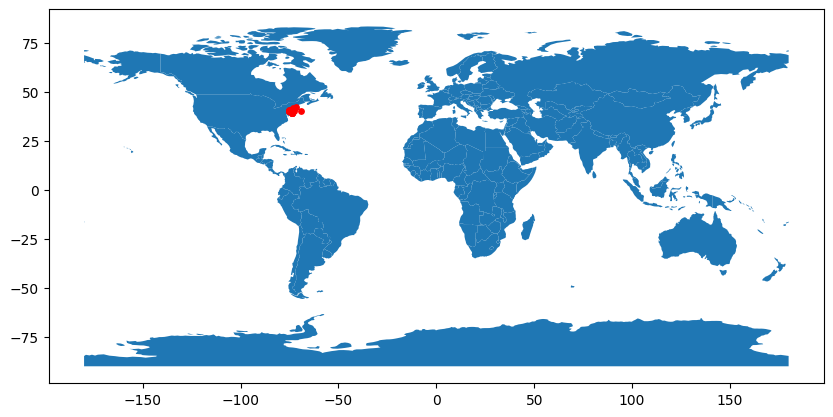

In [9]:
geometry = [Point(xy) for xy in zip(df['pickup_longitude'], df['pickup_latitude'])]
crs={'init':'epsg:4326'}
gdf = GeoDataFrame(geometry=geometry)  
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

In [10]:
df = df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], axis=1 )

In [11]:
df

,fare_amount,distance_run,passenger_count,pickup_monthday,pickup_weekday
0,7.5,1682.265887,1,7,3
1,7.7,2456.046898,1,17,4
2,12.9,5033.215126,1,24,0
3,5.3,1660.640179,3,26,4
4,16.0,4472.640074,5,28,3
...,...,...,...,...,...
199994,3.0,112.139794,1,28,6
199995,7.5,1873.872926,1,14,4
199996,30.9,12842.251110,2,29,0
199997,14.5,3537.493059,1,20,2


# Creación de los conjuntos de test y train

In [12]:
x = df.iloc[:, 1:]
y = pd.DataFrame(df.iloc[:, 0])

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2)

#Mostrar las caracerísticas de los arrays
print('Conjuntos de datos:')
print('xTrain: ' + str(xTrain.shape))
print('xTest: ' + str(xTest.shape))
print('yTrain: ' + str(yTrain.shape))
print('yTest: ' + str(yTest.shape))

Conjuntos de datos:
xTrain: (154564, 4)
xTest: (38641, 4)
yTrain: (154564, 1)
yTest: (38641, 1)


# Regresión lineal

In [13]:
from linReg import LinRegClassifier
import matplotlib.pyplot as plt

In [17]:
classifier = LinRegClassifier(xTrain, yTrain, numIter=5, lRate=0.001)
classifier.train()

[1.35067192e+05 3.83666410e+01 3.54284120e+02 6.89843086e+01
 2.25541175e+01]
[-1.35067192e+02 -3.83666410e-02 -3.54284120e-01 -6.89843086e-02
 -2.25541175e-02]

[6.47548569e+09 1.53721294e+06 1.42188596e+07 2.79351808e+06
 9.05146716e+05]
[-6.47562076e+06 -1.53725131e+03 -1.42192139e+04 -2.79358706e+03
 -9.05169270e+02]

[3.10451954e+14 7.36976797e+10 6.81685881e+11 1.33927999e+11
 4.33949088e+10]
[-3.10458429e+11 -7.36992170e+07 -6.81700100e+08 -1.33930793e+08
 -4.33958139e+07]

[1.48838898e+19 3.53326217e+15 3.26818286e+16 6.42086339e+15
 2.08046699e+15]
[-1.48842003e+16 -3.53333587e+12 -3.26825103e+13 -6.42099732e+12
 -2.08051038e+12]

[7.13573142e+23 1.69393957e+20 1.56685352e+21 3.07833216e+20
 9.97431037e+19]
[-7.13588026e+20 -1.69397490e+17 -1.56688620e+18 -3.07839637e+17
 -9.97451842e+16]



In [15]:
# xTrain.to_numpy()[:, 1]
# xTrain

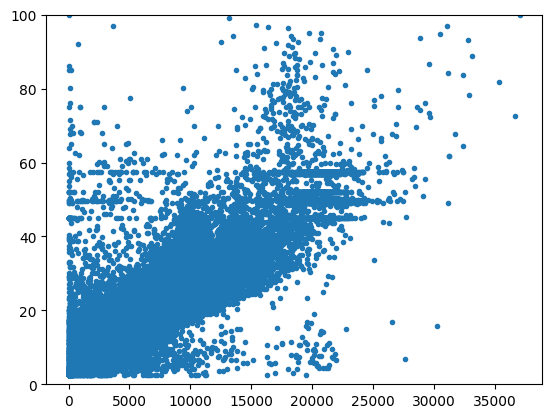

In [16]:
# Distance run

plt.scatter(xTrain['distance_run'].to_numpy(), yTrain, marker=".")
# [classifier.getValue(x) for x in xTrain.to_numpy()]
# plt.plot(xTrain.to_numpy()[:, 1], [classifier.getValue(x) for x in xTrain.to_numpy()], color="red")
plt.ylim([0,np.max(yTrain.to_numpy())])
a = np.linspace(0, np.max(xTrain.to_numpy()[:, 1]), int(np.max(xTrain.to_numpy()[:, 1]) / 100))